<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/ep_model_with_ftn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#font size

In [ ]:
def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '24px'
      break
    }
  }
  '''))
get_ipython().events.register('pre_run_cell', increase_font)

# ep models with ftn

In [ ]:
!pip install optuna
!pip install shap
!pip install catboost

<IPython.core.display.Javascript object>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

import optuna as opt
import catboost as cb
from sklearn.metrics import log_loss
from sklearn.model_selection import GroupKFold, KFold

from scipy.stats import pearsonr
import shap

In [ ]:
project_dir = 'drive/My Drive/nflfastR-data'

In [ ]:
years = range(2022,2024)
pbp = pd.DataFrame()
pp = pd.DataFrame()
ftn = pd.DataFrame()

for year in years:
  _df = pd.read_csv(f"{project_dir}/pbp/season={year}/play_by_play_{year}.csv")
  pbp = pd.concat([pbp,_df])

  _df = pd.read_csv(f"{project_dir}/pbp_participation/season={year}/pbp_participation_{year}.csv")
  pp = pd.concat([pp, _df])

  _df = pd.read_csv(f"{project_dir}/ftn_charting/season={year}/ftn_charting_{year}.csv")
  ftn = pd.concat([ftn, _df])

pbp = pbp.reset_index(drop=True)
pp = pp.reset_index(drop=True)
ftn = ftn.reset_index(drop=True)
pbp = pbp.merge(pp.rename(columns={'nflverse_game_id':'game_id'}), on=['game_id', 'play_id'], suffixes=('', '_pp'))
df = pbp.merge(ftn.rename(columns={'nflverse_game_id':'game_id', 'nflverse_play_id':'play_id'}), on=['game_id', 'play_id'], suffixes=('', '_ftn'), how='left')

<IPython.core.display.Javascript object>

<ipython-input-6-89c69e76696a>:7: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,218,219,220,222,224,226,243,244,245,253,254,255,260,262,263,283,284,301) have mixed types. Specify dtype option on import or set low_memory=False.
  _df = pd.read_csv(f"{project_dir}/pbp/season={year}/play_by_play_{year}.csv")
<ipython-input-6-89c69e76696a>:7: DtypeWarning: Columns (179,180,182,183,205,206,218,219,220,248,249,253,254,255,260,262,263,283,284,332) have mixed types. Specify dtype option on import or set low_memory=False.
  _df = pd.read_csv(f"{project_dir}/pbp/season={year}/play_by_play_{year}.csv")


## ep model setup
steps outlined at
https://opensourcefootball.com/posts/2020-09-28-nflfastr-ep-wp-and-cp-models/  

the biggest lift is engineering a feature for when the next score happens, not specifically what happens on the drive but perhaps multiple changes of possession.  

In [ ]:
# make season-week index
df['seasonweek'] = df['season'].astype(str).add(df['week'].astype(str).str.zfill(2))
df['seasonweek'] = df['seasonweek'].astype(int)

# home/away bool
df['pos_team_home'] = 0
df.loc[df['posteam']==df['home_team'], 'pos_team_home'] = 1

# eras as defined by the original nflfastR EP model
df['era'] = '1999-2001'
df.loc[df['season'].between(2002,2005), 'era'] = '2002-2005'
df.loc[df['season'].between(2006,2013), 'era'] = '2006-2013'
df.loc[df['season'].between(2014,2017), 'era'] = '2014-2017'
df.loc[df['season']>=2018, 'era'] = '2018-current'

# renaming results to "next score" values
df['drive_event'] = (df['fixed_drive_result'].fillna('No Score')
                     .replace(['Punt', 'Touchdown', 'Turnover', 'Field goal',
                               'Turnover on downs', 'End of half',
                               'Missed field goal', 'Opp touchdown', 'Safety'],
                              ['No Score', 'Touchdown', 'No Score',
                               'Field goal', 'No Score', 'No Score', 'No Score',
                               'Opp Touchdown', 'Safety']))

# convert str variables into categorical variables
cols = ['defteam', 'roof', 'era', 'drive_event']
for col in cols:
  df[f'{col}_code'] = df[col].astype('category').cat.codes

# if you want to control for the head coach vs the team, coding the coach
df['pos_coach'] = df['home_coach']
df.loc[df['pos_team_home']==0, 'pos_coach'] = df.loc[df['pos_team_home']==0, 'away_coach']

# convert fg results to bool
df['fg'] = df['field_goal_result'].replace(['made', 'blocked', 'missed'], [1,0,0]).fillna(0)

# label scoring plays (td, fg, safety)
df['scoring_play'] = df.loc[:, ['touchdown', 'fg', 'safety']].sum(axis=1)
# this gives us a text description per row
df['scoring_desc'] = df.loc[:, ['touchdown', 'fg', 'safety']].idxmax(axis=1)

# handle end of game conditions and label as "no score"
df.loc[(df['qtr'].isin([2, 4, 5]))&((df['quarter_end']==1) | (df['desc'].str.contains('END GAME')) |(df['desc'].str.contains('END QUARTER 2'))), 'scoring_desc'] = 'no_score'
df.loc[(df['scoring_play']==0) & (df['scoring_desc']!='no_score'), 'scoring_desc'] = np.nan

# subset to ep model data
_df = df.loc[(df['scoring_play']==1) | (df['scoring_desc']=='no_score'), ['game_id', 'play_id', 'scoring_desc','posteam', 'defteam', 'posteam_score', 'posteam_score_post', 'defteam_score', 'defteam_score_post']]

# feature for what team scores next (posteam or defteam)
_df['next_score_team'] = np.nan
_df.loc[_df['posteam_score']!=_df['posteam_score_post'], 'next_score_team'] = _df.loc[_df['posteam_score']!=_df['posteam_score_post'], 'posteam']
_df.loc[_df['defteam_score']!=_df['defteam_score_post'], 'next_score_team'] = _df.loc[_df['defteam_score']!=_df['defteam_score_post'], 'defteam']

# more engineering for what team scores next based on previous team-score engineering
_df['wtf'] = _df.loc[:, ['posteam_score', 'posteam_score_post', 'defteam_score', 'defteam_score_post']].isnull().sum(axis=1)
_df.loc[(_df['wtf']==2) & (_df['posteam_score_post']>0), 'next_score_team'] = _df.loc[(_df['wtf']==2) & (_df['posteam_score_post']>0), 'posteam']
_df.loc[(_df['wtf']==2) & (_df['defteam_score_post']>0), 'next_score_team'] = _df.loc[(_df['wtf']==2) & (_df['defteam_score_post']>0), 'defteam']
_df.loc[_df['wtf']==4, 'next_score_team'] = np.nan

# append next score team info back to original dataframe
df['next_score_desc'] = _df['scoring_desc']
df['next_score_team'] = _df['next_score_team']

# for null data, fill data with the most recent value
df.loc[:, ['next_score_team', 'next_score_desc']] = df.loc[:, ['next_score_team', 'next_score_desc']].fillna(method='bfill')

# when there's no score, explicitly set nulls
df.loc[df['scoring_desc']=='no_score', 'next_score_team'] = np.nan

# declare whether the pos team or the opp team scored (or didn't)
df['opp'] = ''
df.loc[df['posteam']!=df['next_score_team'], 'opp'] = 'opp_'
df['next_score_target'] = df['opp'].add(df['next_score_desc']).replace('opp_no_score', 'no_score')

# convert to categorical values
df['next_score_target_code'] = df['next_score_target'].astype('category').cat.codes

<IPython.core.display.Javascript object>

In [ ]:
df.columns.values

<IPython.core.display.Javascript object>

array(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       'side_of_field', 'yardline_100', 'game_date',
       'quarter_seconds_remaining', 'half_seconds_remaining',
       'game_seconds_remaining', 'game_half', 'quarter_end', 'drive',
       'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo',
       'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun',
       'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble',
       'pass_length', 'pass_location', 'air_yards', 'yards_after_catch',
       'run_location', 'run_gap', 'field_goal_result', 'kick_distance',
       'extra_point_result', 'two_point_conv_result',
       'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout',
       'timeout_team', 'td_team', 'td_player_name', 'td_player_id',
       'posteam_timeouts_remaining', 'defteam_timeouts_remaining',
       'total_home_score', 'total_away_score', 'posteam_score'

## modeling methods  

you'll need these steps:  
1. make the ep model as is (called the "base model" or "naive model")    
2. make a new ep model with new features (called the "candidate model" or "experimental model")    
3. make a sham feature model with a representative but "noisy" feature(s) that mimic the distribution of your new features (called the "sham model" or "noise model")   

You need the base model to compare whether or not your model is more accurate. if it isn't more accurate than the base model, then it's possible your added features actually decrease the loss/acc of your model. Therefore, you wouldn't want to continue to validate the candidate model (since it is a weaker model even with more features and new features).  

If your candidate model beats the base model, you need to rule out random chance -- for example, is it possible that your new feature just so happens to improve the model simply because of the distribution of the data, and not actually the row-level specificity of the data. For instance: weekday may be a good feature but if you randomly sample over the weekday and get the same accuracy, then it may be a good-but-weak feature; it's possible that days-between-games is a better, more accurate feature than simply the weekday. So, the sham model is suppose to mimic the distribution of your new feature, but not in a precise way. You can either randomly sample over your feature (literally just mix up the rows) or create a distribution and sample over a distribution (more robust, but less accurate most likely).  

If your sham model beats the base model, you will want to compare sham to candidate. if they are equivalent, then your new feature may just be lucky noise. However, if the sham model underperforms compare to the candidate model, then your new model may actually have improvements over the base. And of course, if the sham model is worse than the base model, and the candidate model is better than the base model, then the new candidate model should be the new accepted model.  

TLDR:  
Base model is your starting point.  
Candidate model is the model you want. If it's better than the base, keep going.  
Sham model is the control for randomness.

candidate > base > sham = good!  
candidate > sham > base = good! but needs some investigation  
candidate ~= sham > base = not great, probably bad -- need to evaluate your new features  
base > candidate = reject new model  

### Base model  

In [ ]:
feats = ['season', 'half_seconds_remaining',
         'yardline_100', 'pos_team_home',
         'roof_code', 'down',
         'ydstogo', 'era_code',
         'posteam_timeouts_remaining',
         'defteam_timeouts_remaining']

target = 'next_score_target_code'
n_classes = df[target].unique().shape[0]


<IPython.core.display.Javascript object>

In [ ]:
def tune(trial):
  iterations = trial.suggest_int('iterations', 200,600)
  eta = trial.suggest_float('eta', 0,0.3)
  reg_lambda = trial.suggest_float('l2', 0,2)
  model = cb.CatBoostClassifier(iterations=iterations,verbose=False,
                                loss_function='MultiClass',
                                classes_count=n_classes,
                                eta=eta,reg_lambda=reg_lambda)
  model.fit(train_data.loc[:, feats], train_data[target])
  _df = pd.DataFrame(model.predict_proba(test_data.loc[:, feats]), index=test_data.index)
  loss = log_loss(test_data[target], _df)
  return loss


<IPython.core.display.Javascript object>

In [ ]:
model_data = df.dropna(subset=feats+[target])
model_data.shape

<IPython.core.display.Javascript object>

(48822, 428)

In [ ]:
folds = model_data['seasonweek'].unique().shape[0]
dfp_folds = 2
kf = KFold(dfp_folds, shuffle=True)
dfp = pd.DataFrame()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  study = opt.create_study(direction='minimize')
  study.optimize(tune, n_trials=20)
  _dfp = pd.DataFrame([study.best_params])
  dfp = pd.concat([dfp,_dfp])
dfp

<IPython.core.display.Javascript object>

[I 2023-09-28 02:11:05,094] A new study created in memory with name: no-name-6fc38367-cb2b-4e27-a647-8bdfb5345d37
[I 2023-09-28 02:11:13,947] Trial 0 finished with value: 1.2545315120904577 and parameters: {'iterations': 415, 'eta': 0.2044352358720643, 'l2': 1.3397796193591613}. Best is trial 0 with value: 1.2545315120904577.
[I 2023-09-28 02:11:26,470] Trial 1 finished with value: 1.2753681788241416 and parameters: {'iterations': 482, 'eta': 0.012491536999727715, 'l2': 1.1498538694343643}. Best is trial 0 with value: 1.2545315120904577.
[I 2023-09-28 02:11:38,788] Trial 2 finished with value: 1.2736689072926757 and parameters: {'iterations': 462, 'eta': 0.29032838650041176, 'l2': 0.7100771023738661}. Best is trial 0 with value: 1.2545315120904577.
[I 2023-09-28 02:11:50,961] Trial 3 finished with value: 1.2488997844937442 and parameters: {'iterations': 461, 'eta': 0.1505805993670098, 'l2': 1.7934228986028549}. Best is trial 3 with value: 1.2488997844937442.
[I 2023-09-28 02:11:52,855]

,iterations,eta,l2
0,292,0.153830,0.801020
0,295,0.149769,0.948853


In [ ]:
_pp = {
    'verbose':False,
    'loss_function':'MultiClass',
    'classes_count':n_classes
}
pp = dfp.rename(columns={'l2':'reg_lambda'}).mean()
pp['iterations'] = pp['iterations'].round().astype(int)
pp = pp.to_dict()
opt_pp = {**_pp, **pp}
opt_pp


<IPython.core.display.Javascript object>

{'verbose': False,
 'loss_function': 'MultiClass',
 'classes_count': 7,
 'iterations': 294.0,
 'eta': 0.1517997094363445,
 'reg_lambda': 0.8749361105494198}

In [ ]:
kf = GroupKFold(folds)
preds = pd.DataFrame()
for train_idx, test_idx in kf.split(model_data, groups=model_data['seasonweek']):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  model = cb.CatBoostClassifier(**opt_pp)
  model.fit(train_data.loc[:, feats], train_data[target])
  _df = pd.DataFrame(model.predict_proba(test_data.loc[:, feats]), index=test_data.index)
  preds = pd.concat([preds, _df])
model_data = pd.concat([model_data, preds], axis=1)


<IPython.core.display.Javascript object>

In [ ]:
mapper = model_data.loc[:, ['next_score_target', 'next_score_target_code']].drop_duplicates().set_index('next_score_target_code').to_dict()['next_score_target']
mapper = {k:f"{v}_pred" for k,v in mapper.items()}
model_data = model_data.rename(columns=mapper)
model_data[f"next_score_target_pred"] = model_data.loc[:, mapper.values()].idxmax(axis=1).str[:-5]

mapper = model_data.loc[:, ['next_score_target', 'next_score_target_code']].drop_duplicates().set_index('next_score_target').to_dict()['next_score_target_code']
model_data[f"next_score_target_code_pred"] = model_data[f"next_score_target_pred"].map(mapper)

_dict = model_data.loc[:, ['next_score_target', 'next_score_target_code']].drop_duplicates().set_index('next_score_target_code').to_dict()['next_score_target']
pred_cols = [f"{v}_pred" for k,v in _dict.items()]
score_map = {k:s for (k,v),s in zip(mapper.items(), [-3,3,-7,7,0,2,-2])}
model_data['ep_pred'] = (model_data['opp_fg_pred']
                      .mul(-3)
                      .add(model_data['fg_pred']
                           .mul(3))
                      .add(model_data['opp_touchdown_pred']
                           .mul(-7))
                      .add(model_data['touchdown_pred']
                           .mul(7))
                      .add(model_data['no_score_pred']
                           .mul(0))
                      .add(model_data['safety_pred']
                           .mul(2))
                      .add(model_data['opp_safety_pred']
                           .mul(-2)))
model_data['ap'] = model_data['next_score_target'].map(score_map)


<IPython.core.display.Javascript object>

In [ ]:
model_data.columns.values

<IPython.core.display.Javascript object>

array(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       'side_of_field', 'yardline_100', 'game_date',
       'quarter_seconds_remaining', 'half_seconds_remaining',
       'game_seconds_remaining', 'game_half', 'quarter_end', 'drive',
       'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo',
       'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun',
       'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble',
       'pass_length', 'pass_location', 'air_yards', 'yards_after_catch',
       'run_location', 'run_gap', 'field_goal_result', 'kick_distance',
       'extra_point_result', 'two_point_conv_result',
       'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout',
       'timeout_team', 'td_team', 'td_player_name', 'td_player_id',
       'posteam_timeouts_remaining', 'defteam_timeouts_remaining',
       'total_home_score', 'total_away_score', 'posteam_score'

In [ ]:
model_data.head()

<IPython.core.display.Javascript object>

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,no_score_pred,opp_fg_pred,opp_safety_pred,opp_touchdown_pred,safety_pred,touchdown_pred,next_score_target_pred,next_score_target_code_pred,ep_pred,ap
2,68,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,0.000622,0.206863,0.000059,0.171469,0.009159,0.397485,touchdown,6,1.622755,-3
3,89,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,0.000375,0.087570,0.000071,0.091478,0.007352,0.515751,touchdown,6,3.613975,-3
4,115,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,0.000346,0.106347,0.000048,0.112688,0.005943,0.505711,touchdown,6,3.250666,-3
5,136,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,0.000319,0.138317,0.000025,0.116431,0.006033,0.534723,touchdown,6,3.137562,-3
6,172,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,0.000568,0.473146,0.000117,0.229090,0.033047,0.131211,opp_fg,2,-1.640265,-3


<IPython.core.display.Javascript object>

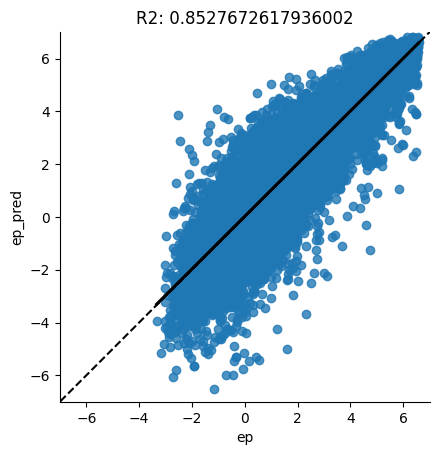

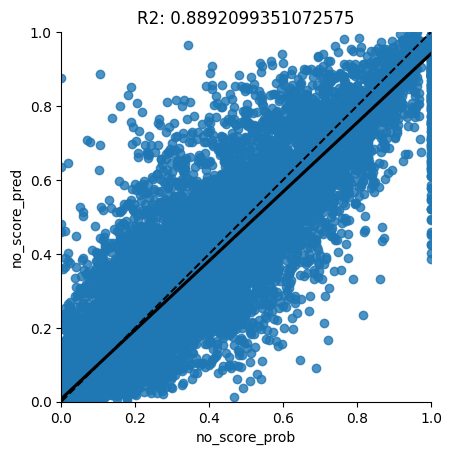

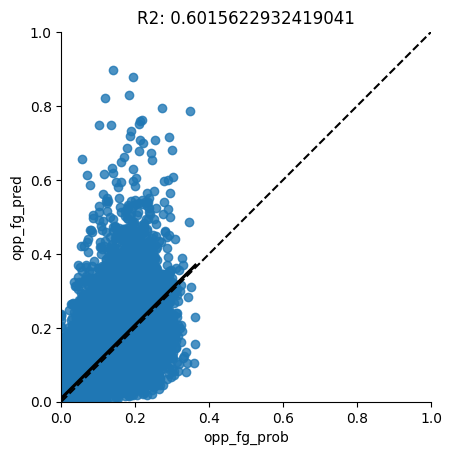

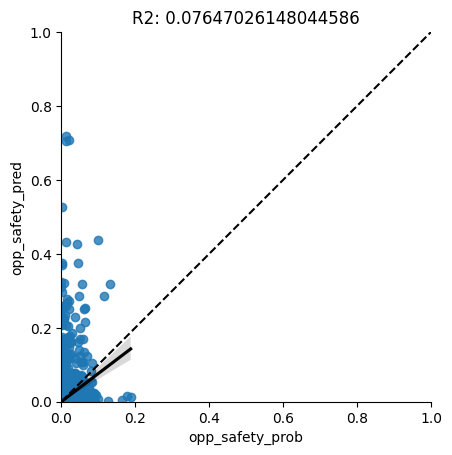

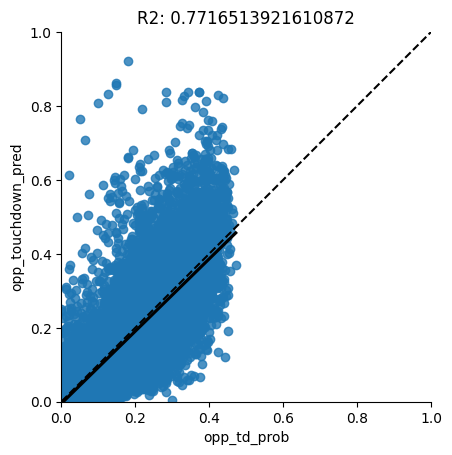

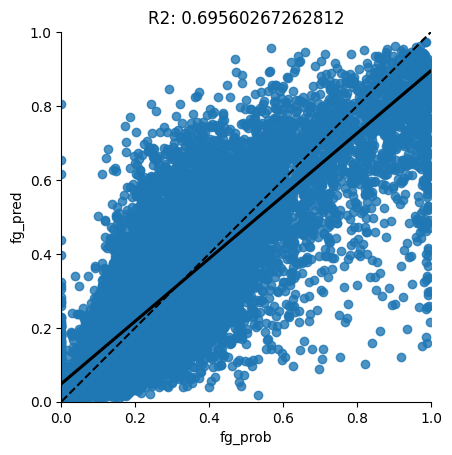

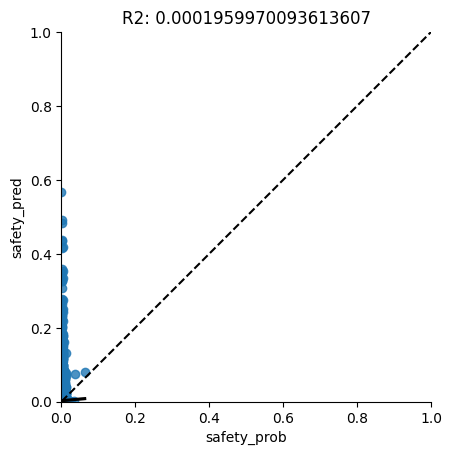

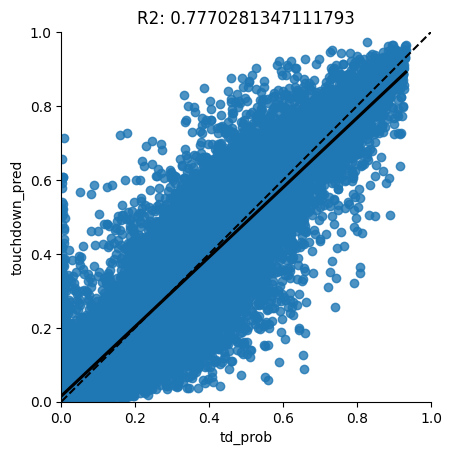

In [ ]:
r2 = pearsonr(model_data['ep'], model_data['ep_pred'])[0]**2
fig = sns.regplot(data=model_data, x='ep', y='ep_pred', line_kws={'color':'k'})
plt.plot([-10,10], [-10,10], 'k--')
plt.title(f"R2: {r2}")
plt.xlim(-7,7)
plt.ylim(-7,7)
sns.despine()
fig.set_aspect('equal')
plt.show()

z1 = ['no_score_prob', 'opp_fg_prob',
      'opp_safety_prob', 'opp_td_prob',
      'fg_prob', 'safety_prob', 'td_prob']
z2 = [
    'no_score_pred','opp_fg_pred', 'opp_safety_pred',
    'opp_touchdown_pred','fg_pred',
    'safety_pred', 'touchdown_pred'
]

for x,y in zip(z1,z2):
  r2 = pearsonr(model_data[x], model_data[y])[0]**2
  fig = sns.regplot(data=model_data, x=x, y=y, line_kws={'color':'k'})
  plt.plot([-10,10], [-10,10], 'k--')
  plt.title(f"R2: {r2}")
  plt.xlim(0,1)
  plt.ylim(0,1)
  sns.despine()
  fig.set_aspect('equal')
  plt.show()

### candidate model  
we're trying to use pre-snap or near-pre-snap features -- similar to the concept of the original EP feature set. since we can't know what play type is ran until after the play -- and events during the play may not necessarily be aligned with my concept of the EP model -- it makes sense to try and stay as close to the types of features that have already been accepted into the EP model. these tend to be game state features. i can argue pre snap features are aligned with game state features -- the play hasn't occurred yet, so we don't know any of the end results within the model. the snap hasn't occurred yet, so we don't know any of the within-play design (like play action or trick play situations). but we can infer things like field positioning, qb positioning, and personnel on the field. we can further make an argument for pre-snap events like whether it is a no-huddle play or if a play had pre-snap motion. I believe these would all be in line with my current understanding of what the EP model _should_ take into account. However, it is obviously very possible to include many other features (within or not within my personal methodology for EP innovation).  

using FTN's data:

starting hash (this is left, middle, or right in terms of field positioning)   
qb_location (this is under center, pistol, or shotgun)  
n_offense_backfield  
n_defense_box  
is_no_huddle  
is_motion  

In [ ]:
new_feats = ['starting_hash', 'qb_location',
             'n_offense_backfield', 'n_defense_box',
             'is_no_huddle', 'is_motion']

feats = ['season', 'half_seconds_remaining',
         'yardline_100', 'pos_team_home',
         'roof_code', 'down',
         'ydstogo', 'era_code',
         'posteam_timeouts_remaining',
         'defteam_timeouts_remaining']

target = 'next_score_target_code'
n_classes = df[target].unique().shape[0]


<IPython.core.display.Javascript object>

In [ ]:
for feat in new_feats:
  model_data[f"{feat}_code"] = model_data[feat].astype('category').cat.codes

new_feats = [f"{feat}_code" for feat in new_feats]

<IPython.core.display.Javascript object>

In [ ]:
def tune(trial):
  iterations = trial.suggest_int('iterations', 200,600)
  eta = trial.suggest_float('eta', 0,0.3)
  reg_lambda = trial.suggest_float('l2', 0,2)
  model = cb.CatBoostClassifier(iterations=iterations,verbose=False,
                                loss_function='MultiClass',
                                classes_count=n_classes,
                                eta=eta,reg_lambda=reg_lambda)
  model.fit(train_data.loc[:, feats+new_feats], train_data[target])
  _df = pd.DataFrame(model.predict_proba(test_data.loc[:, feats+new_feats]), index=test_data.index)
  loss = log_loss(test_data[target], _df)
  return loss


<IPython.core.display.Javascript object>

In [ ]:
# model_data = df.dropna(subset=feats+[target])
# model_data.shape

<IPython.core.display.Javascript object>

(48822, 428)

In [ ]:
folds = model_data['seasonweek'].unique().shape[0]
dfp_folds = 2
kf = KFold(dfp_folds, shuffle=True)
dfp = pd.DataFrame()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  study = opt.create_study(direction='minimize')
  study.optimize(tune, n_trials=20)
  _dfp = pd.DataFrame([study.best_params])
  dfp = pd.concat([dfp,_dfp])
dfp

<IPython.core.display.Javascript object>

[I 2023-09-28 03:35:40,643] A new study created in memory with name: no-name-e1f3bf5d-f4da-4b07-9146-8707450fdfea
[I 2023-09-28 03:35:59,485] Trial 0 finished with value: 1.2484580160881182 and parameters: {'iterations': 472, 'eta': 0.1215185526016854, 'l2': 0.8025314286994922}. Best is trial 0 with value: 1.2484580160881182.
[I 2023-09-28 03:36:18,689] Trial 1 finished with value: 1.2548380403075186 and parameters: {'iterations': 565, 'eta': 0.13104692731056297, 'l2': 0.7557185320860444}. Best is trial 0 with value: 1.2484580160881182.
[I 2023-09-28 03:36:35,080] Trial 2 finished with value: 1.253335128848714 and parameters: {'iterations': 503, 'eta': 0.03170889090349583, 'l2': 1.4550922046984118}. Best is trial 0 with value: 1.2484580160881182.
[I 2023-09-28 03:36:46,844] Trial 3 finished with value: 1.2622378374358507 and parameters: {'iterations': 306, 'eta': 0.1942517447464522, 'l2': 0.13501448829387241}. Best is trial 0 with value: 1.2484580160881182.
[I 2023-09-28 03:36:53,607] 

,iterations,eta,l2
0,537,0.058109,0.430726
0,537,0.062946,1.243546


In [ ]:
_pp = {
    'verbose':False,
    'loss_function':'MultiClass',
    'classes_count':n_classes
}
pp = dfp.rename(columns={'l2':'reg_lambda'}).mean()
pp['iterations'] = pp['iterations'].round().astype(int)
pp = pp.to_dict()
opt_pp = {**_pp, **pp}
opt_pp


<IPython.core.display.Javascript object>

{'verbose': False,
 'loss_function': 'MultiClass',
 'classes_count': 7,
 'iterations': 537.0,
 'eta': 0.06052738333911695,
 'reg_lambda': 0.8371357521144646}

In [ ]:
kf = GroupKFold(folds)
preds = pd.DataFrame()
for train_idx, test_idx in tqdm(kf.split(model_data, groups=model_data['seasonweek']), total=folds):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  model = cb.CatBoostClassifier(**opt_pp)
  model.fit(train_data.loc[:, feats+new_feats], train_data[target])
  _df = pd.DataFrame(model.predict_proba(test_data.loc[:, feats+new_feats]), index=test_data.index)
  preds = pd.concat([preds, _df])
model_data = pd.concat([model_data, preds], axis=1)


<IPython.core.display.Javascript object>

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
mapper = model_data.loc[:, ['next_score_target', 'next_score_target_code']].drop_duplicates().set_index('next_score_target_code').to_dict()['next_score_target']
mapper = {k:f"{v}_ftn" for k,v in mapper.items()}
model_data = model_data.rename(columns=mapper)
model_data[f"next_score_target_ftn"] = model_data.loc[:, mapper.values()].idxmax(axis=1).str[:-5]

mapper = model_data.loc[:, ['next_score_target', 'next_score_target_code']].drop_duplicates().set_index('next_score_target').to_dict()['next_score_target_code']
model_data[f"next_score_target_code_ftn"] = model_data[f"next_score_target_ftn"].map(mapper)

_dict = model_data.loc[:, ['next_score_target', 'next_score_target_code']].drop_duplicates().set_index('next_score_target_code').to_dict()['next_score_target']
pred_cols = [f"{v}_ftn" for k,v in _dict.items()]
score_map = {k:s for (k,v),s in zip(mapper.items(), [-3,3,-7,7,0,2,-2])}
model_data['ep_ftn'] = (model_data['opp_fg_ftn']
                      .mul(-3)
                      .add(model_data['fg_ftn']
                           .mul(3))
                      .add(model_data['opp_touchdown_ftn']
                           .mul(-7))
                      .add(model_data['touchdown_ftn']
                           .mul(7))
                      .add(model_data['no_score_ftn']
                           .mul(0))
                      .add(model_data['safety_ftn']
                           .mul(2))
                      .add(model_data['opp_safety_ftn']
                           .mul(-2)))
model_data['ap'] = model_data['next_score_target'].map(score_map)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

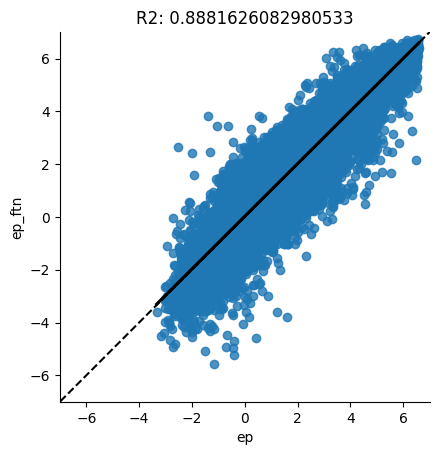

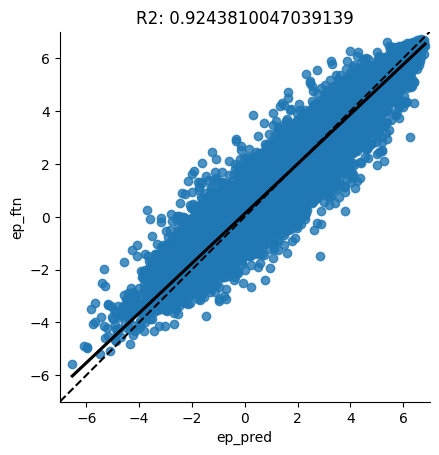

vs original



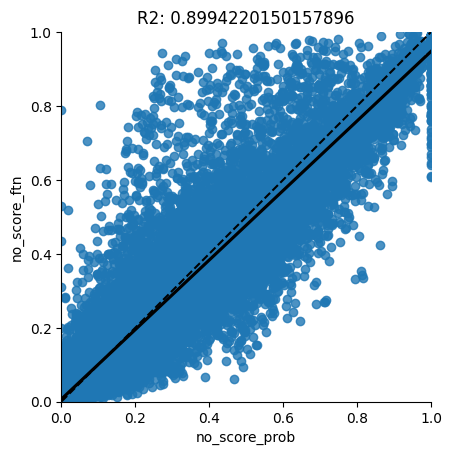

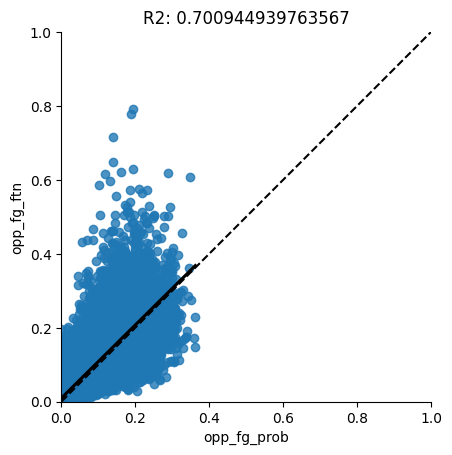

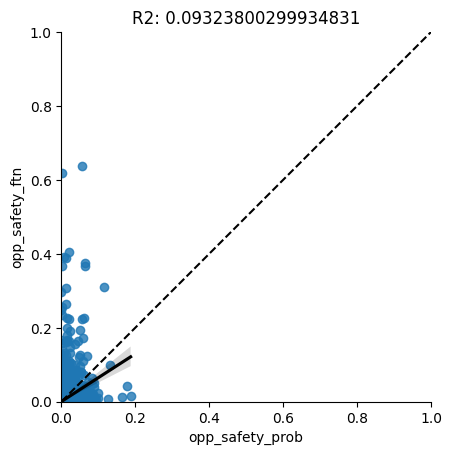

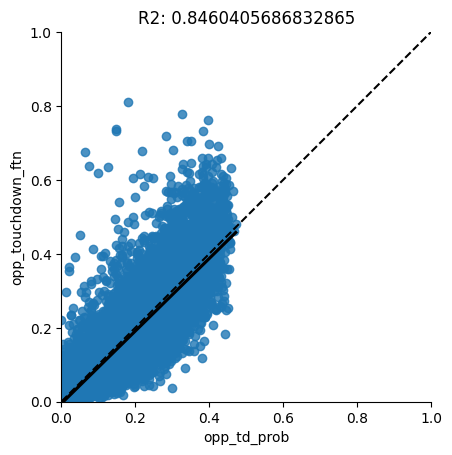

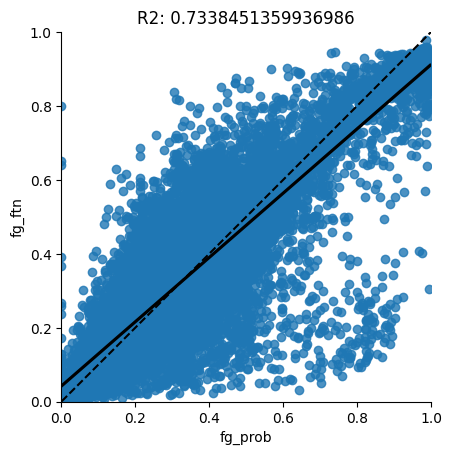

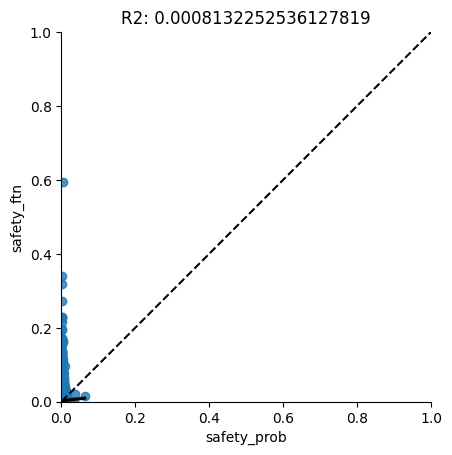

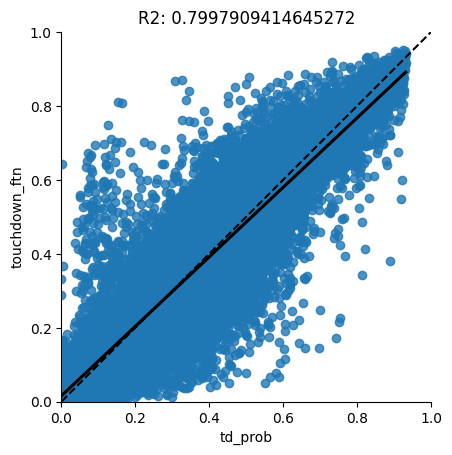

vs base



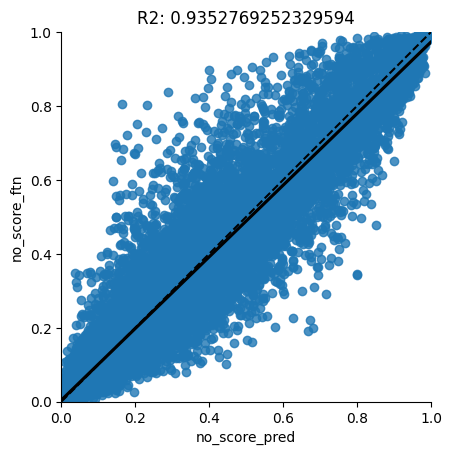

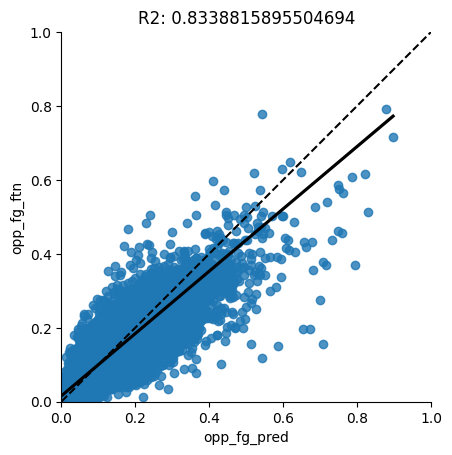

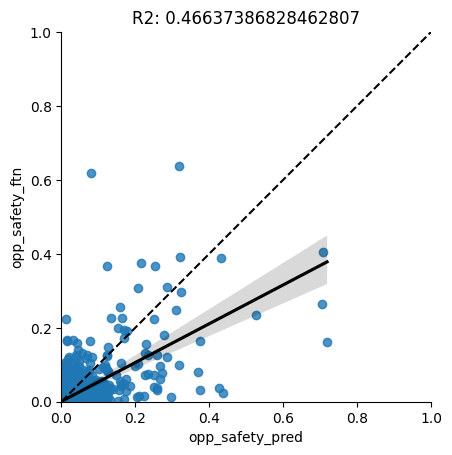

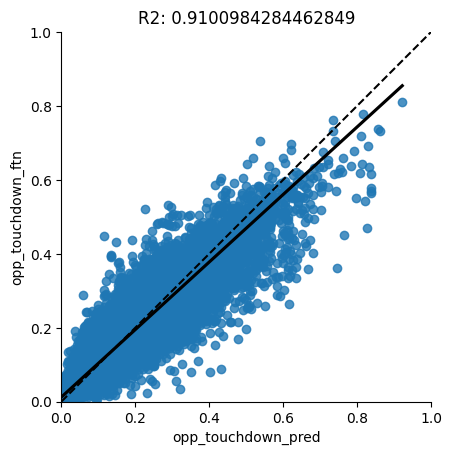

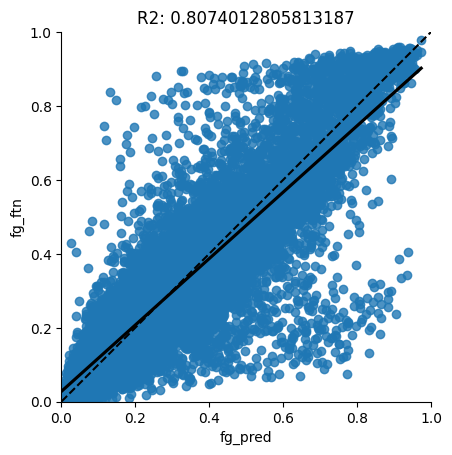

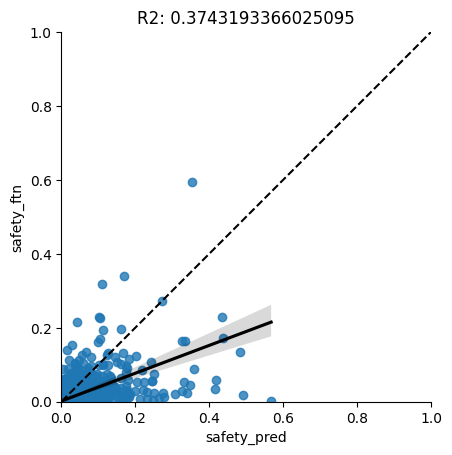

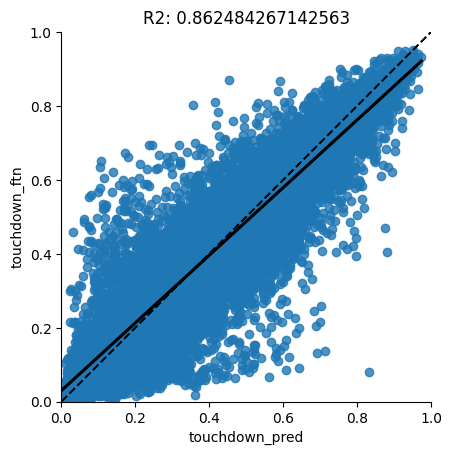

In [ ]:
r2 = pearsonr(model_data['ep'], model_data['ep_ftn'])[0]**2
fig = sns.regplot(data=model_data, x='ep', y='ep_ftn', line_kws={'color':'k'})
plt.plot([-10,10], [-10,10], 'k--')
plt.title(f"R2: {r2}")
plt.xlim(-7,7)
plt.ylim(-7,7)
sns.despine()
fig.set_aspect('equal')
plt.show()

r2 = pearsonr(model_data['ep_pred'], model_data['ep_ftn'])[0]**2
fig = sns.regplot(data=model_data, x='ep_pred', y='ep_ftn', line_kws={'color':'k'})
plt.plot([-10,10], [-10,10], 'k--')
plt.title(f"R2: {r2}")
plt.xlim(-7,7)
plt.ylim(-7,7)
sns.despine()
fig.set_aspect('equal')
plt.show()

z1 = ['no_score_prob', 'opp_fg_prob',
      'opp_safety_prob', 'opp_td_prob',
      'fg_prob', 'safety_prob', 'td_prob']

z2 = [
    'no_score_pred','opp_fg_pred', 'opp_safety_pred',
    'opp_touchdown_pred','fg_pred',
    'safety_pred', 'touchdown_pred'
]

z3 = [
    'no_score_ftn','opp_fg_ftn', 'opp_safety_ftn',
    'opp_touchdown_ftn','fg_ftn',
    'safety_ftn', 'touchdown_ftn'
]

print('vs original\n')
for x,y in zip(z1,z3):
  r2 = pearsonr(model_data[x], model_data[y])[0]**2
  fig = sns.regplot(data=model_data, x=x, y=y, line_kws={'color':'k'})
  plt.plot([-10,10], [-10,10], 'k--')
  plt.title(f"R2: {r2}")
  plt.xlim(0,1)
  plt.ylim(0,1)
  sns.despine()
  fig.set_aspect('equal')
  plt.show()

print('vs base\n')
for x,y in zip(z2,z3):
  r2 = pearsonr(model_data[x], model_data[y])[0]**2
  fig = sns.regplot(data=model_data, x=x, y=y, line_kws={'color':'k'})
  plt.plot([-10,10], [-10,10], 'k--')
  plt.title(f"R2: {r2}")
  plt.xlim(0,1)
  plt.ylim(0,1)
  sns.despine()
  fig.set_aspect('equal')
  plt.show()

### sham model  
this is the same as the candidate model, except we randomly sample over the new features and see if simply adding new features improves the model -- so the accuracy of the row-level doesn't matter in this case. Rather, just the fact that there are more columns of data, and there are new distributions to interact over.  

In [ ]:
new_feats = ['starting_hash', 'qb_location',
             'n_offense_backfield', 'n_defense_box',
             'is_no_huddle', 'is_motion']

feats = ['season', 'half_seconds_remaining',
         'yardline_100', 'pos_team_home',
         'roof_code', 'down',
         'ydstogo', 'era_code',
         'posteam_timeouts_remaining',
         'defteam_timeouts_remaining']

target = 'next_score_target_code'
n_classes = df[target].unique().shape[0]

new_feats = [f"{feat}_code" for feat in new_feats]
for col in new_feats:
  _s = model_data[col].sample(model_data.shape[0])
  _s.index = model_data.index
  model_data[f"{col}_sham"] = _s

new_feats = [f"{feat}_sham" for feat in new_feats]

<IPython.core.display.Javascript object>

In [ ]:
# model_data = df.dropna(subset=feats+[target])
# model_data.shape

<IPython.core.display.Javascript object>

(48822, 428)

In [ ]:
# _pp = {
#     'verbose':False,
#     'loss_function':'MultiClass',
#     'classes_count':n_classes
# }
# pp = dfp.rename(columns={'l2':'reg_lambda'}).mean()
# pp['iterations'] = pp['iterations'].round().astype(int)
# pp = pp.to_dict()
# opt_pp = {**_pp, **pp}
opt_pp


<IPython.core.display.Javascript object>

{'verbose': False,
 'loss_function': 'MultiClass',
 'classes_count': 7,
 'iterations': 537.0,
 'eta': 0.06052738333911695,
 'reg_lambda': 0.8371357521144646}

In [ ]:
kf = GroupKFold(folds)
preds = pd.DataFrame()
for train_idx, test_idx in tqdm(kf.split(model_data, groups=model_data['seasonweek']), total=folds):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  model = cb.CatBoostClassifier(**opt_pp)
  model.fit(train_data.loc[:, feats+new_feats], train_data[target])
  _df = pd.DataFrame(model.predict_proba(test_data.loc[:, feats+new_feats]), index=test_data.index)
  preds = pd.concat([preds, _df])
model_data = pd.concat([model_data, preds], axis=1)


<IPython.core.display.Javascript object>

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
mapper = model_data.loc[:, ['next_score_target', 'next_score_target_code']].drop_duplicates().set_index('next_score_target_code').to_dict()['next_score_target']
mapper = {k:f"{v}_sham" for k,v in mapper.items()}
model_data = model_data.rename(columns=mapper)
model_data[f"next_score_target_sham"] = model_data.loc[:, mapper.values()].idxmax(axis=1).str[:-5]

mapper = model_data.loc[:, ['next_score_target', 'next_score_target_code']].drop_duplicates().set_index('next_score_target').to_dict()['next_score_target_code']
model_data[f"next_score_target_code_sham"] = model_data[f"next_score_target_sham"].map(mapper)

_dict = model_data.loc[:, ['next_score_target', 'next_score_target_code']].drop_duplicates().set_index('next_score_target_code').to_dict()['next_score_target']
pred_cols = [f"{v}_sham" for k,v in _dict.items()]
score_map = {k:s for (k,v),s in zip(mapper.items(), [-3,3,-7,7,0,2,-2])}
model_data['ep_sham'] = (model_data['opp_fg_sham']
                      .mul(-3)
                      .add(model_data['fg_sham']
                           .mul(3))
                      .add(model_data['opp_touchdown_sham']
                           .mul(-7))
                      .add(model_data['touchdown_sham']
                           .mul(7))
                      .add(model_data['no_score_sham']
                           .mul(0))
                      .add(model_data['safety_sham']
                           .mul(2))
                      .add(model_data['opp_safety_sham']
                           .mul(-2)))
model_data['ap'] = model_data['next_score_target'].map(score_map)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

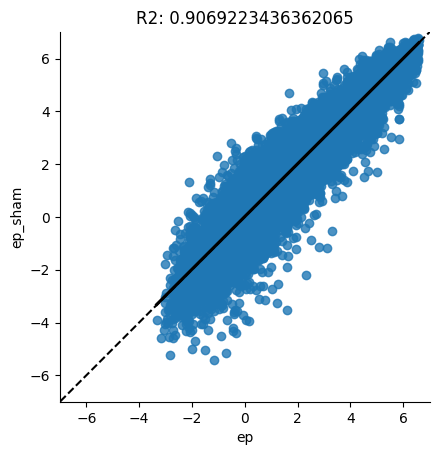

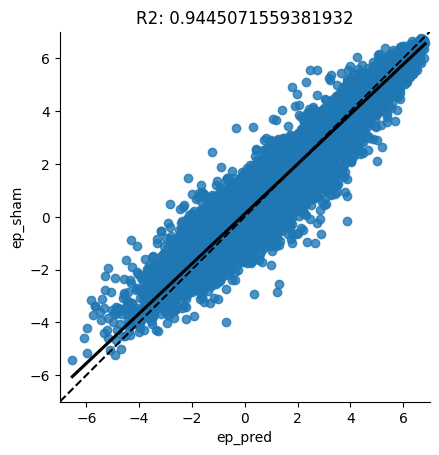

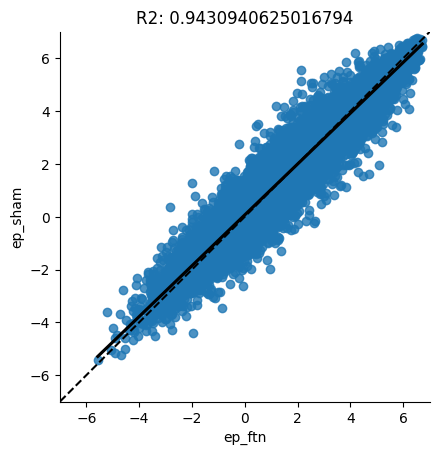

vs original



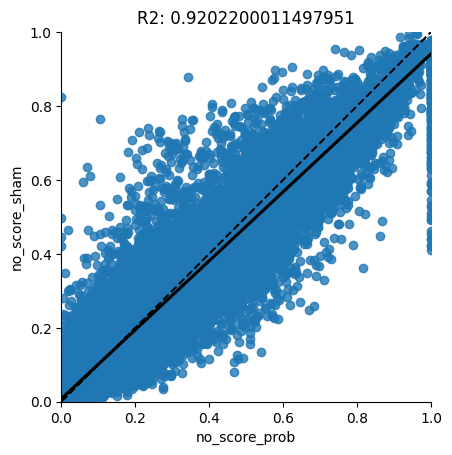

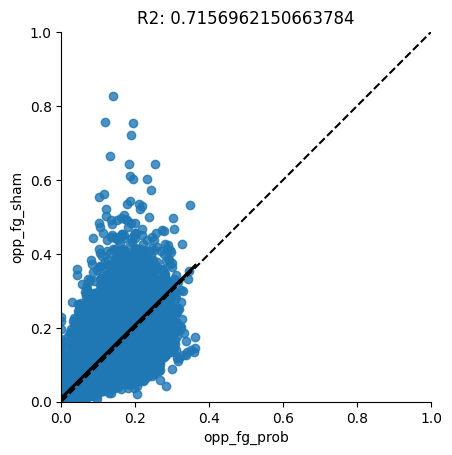

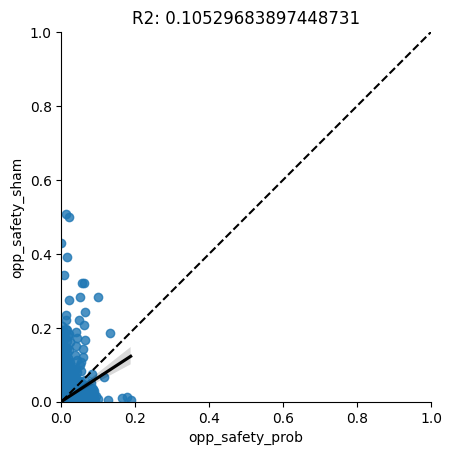

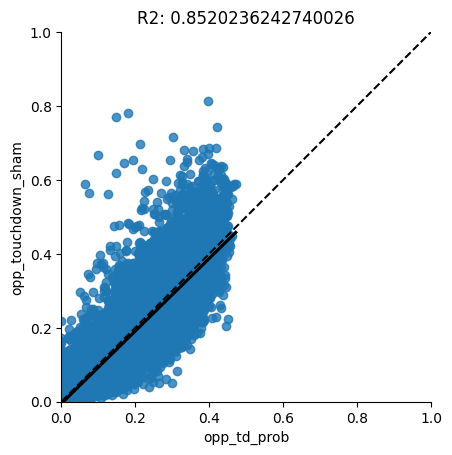

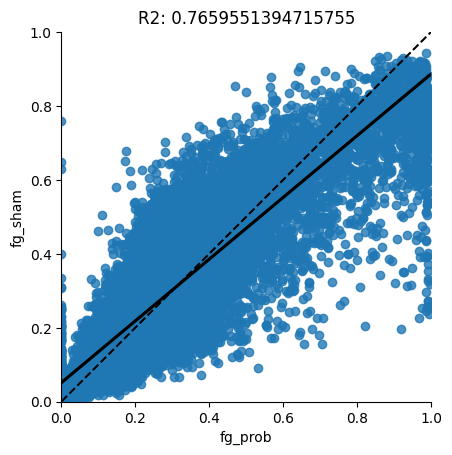

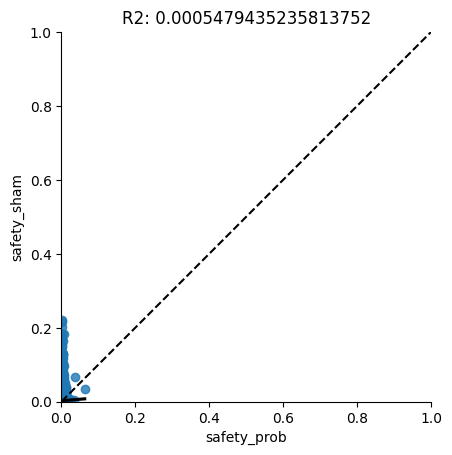

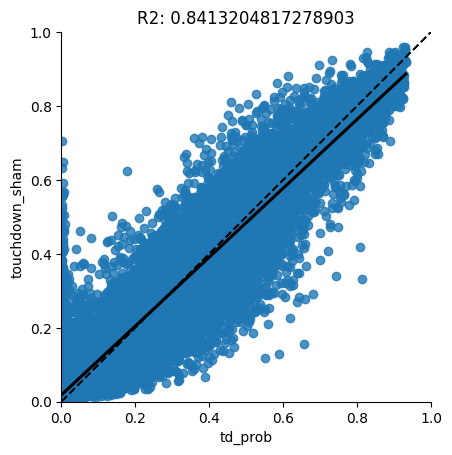

vs base



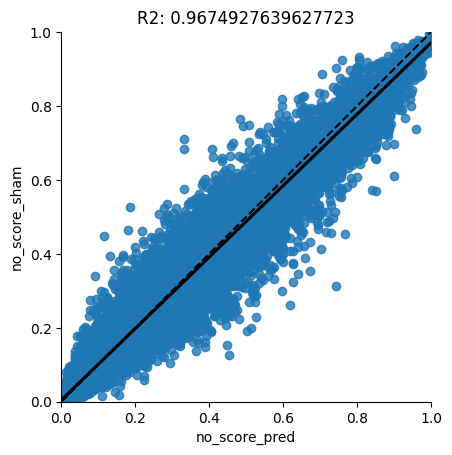

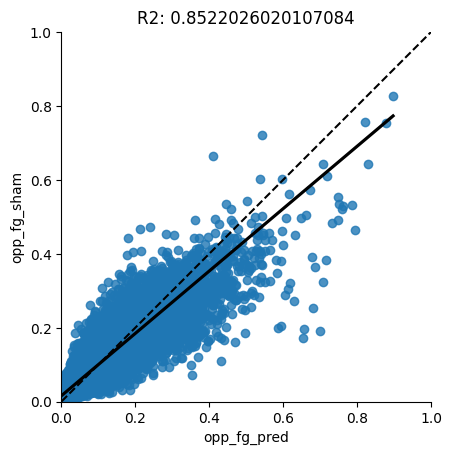

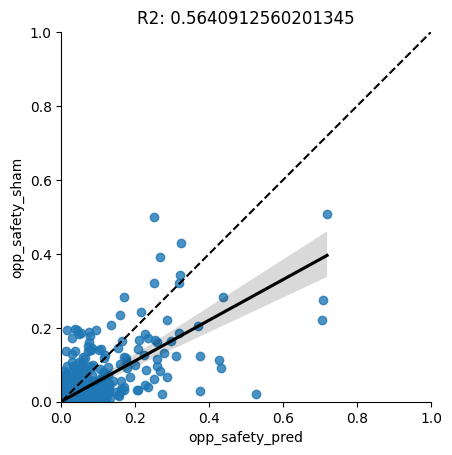

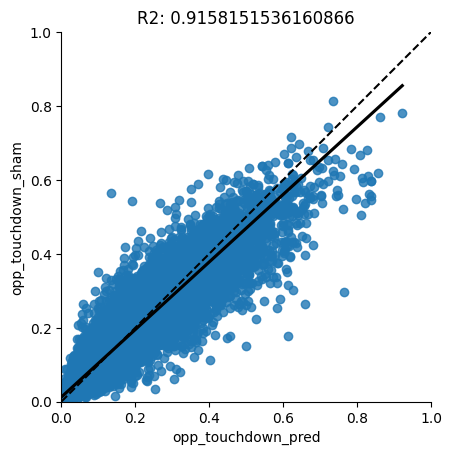

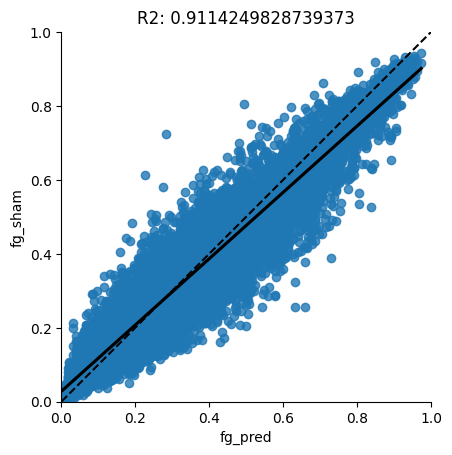

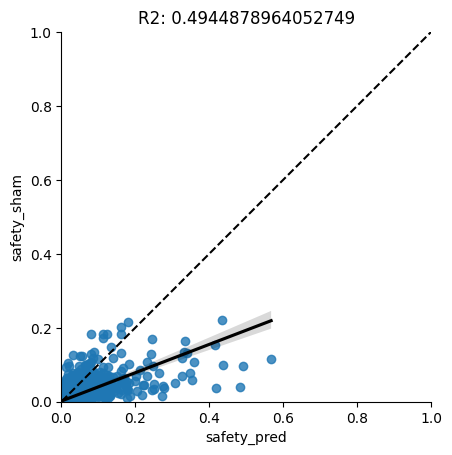

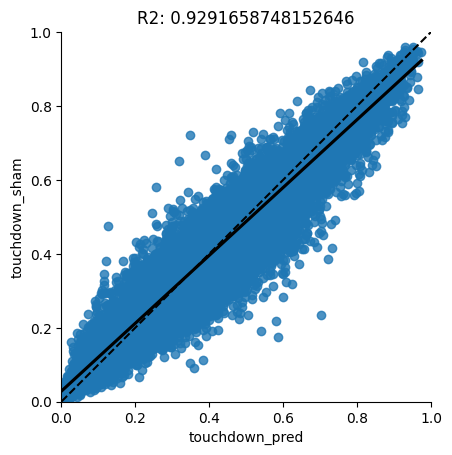

vs ftn



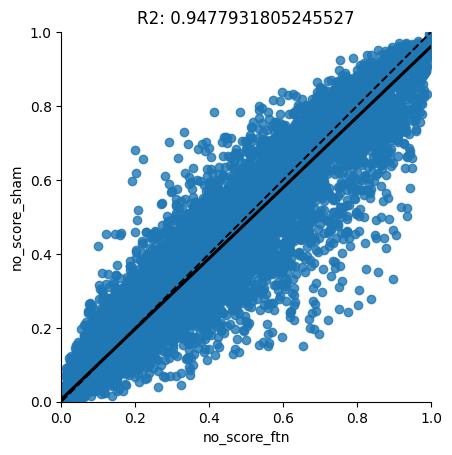

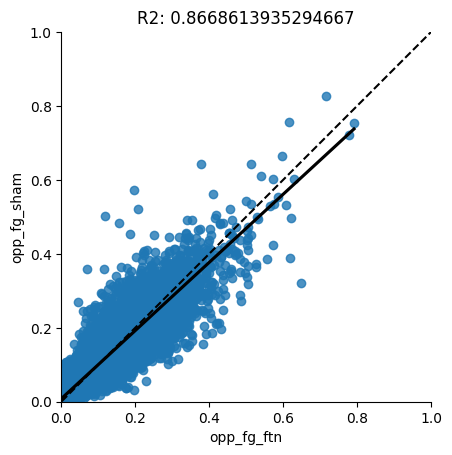

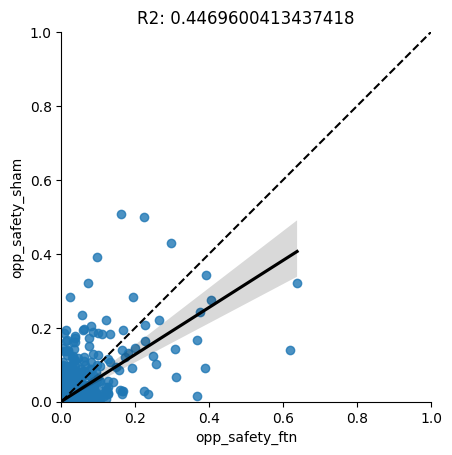

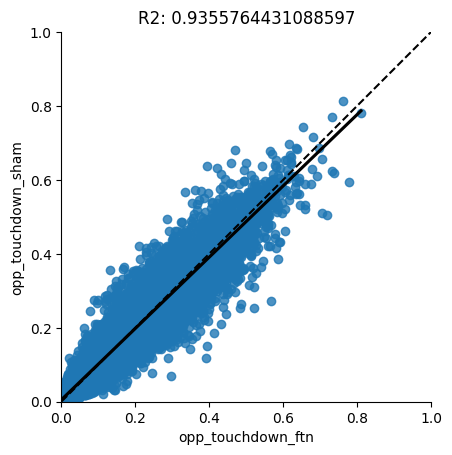

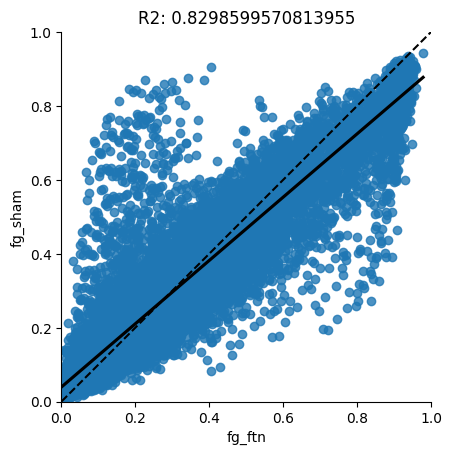

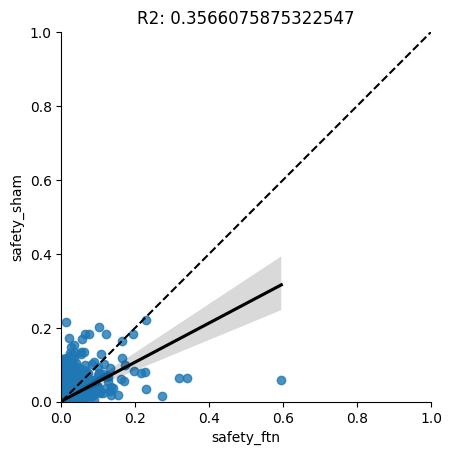

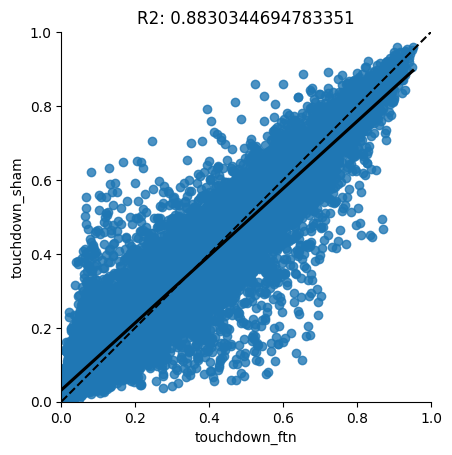

In [ ]:
r2 = pearsonr(model_data['ep'], model_data['ep_sham'])[0]**2
fig = sns.regplot(data=model_data, x='ep', y='ep_sham', line_kws={'color':'k'})
plt.plot([-10,10], [-10,10], 'k--')
plt.title(f"R2: {r2}")
plt.xlim(-7,7)
plt.ylim(-7,7)
sns.despine()
fig.set_aspect('equal')
plt.show()

r2 = pearsonr(model_data['ep_pred'], model_data['ep_sham'])[0]**2
fig = sns.regplot(data=model_data, x='ep_pred', y='ep_sham', line_kws={'color':'k'})
plt.plot([-10,10], [-10,10], 'k--')
plt.title(f"R2: {r2}")
plt.xlim(-7,7)
plt.ylim(-7,7)
sns.despine()
fig.set_aspect('equal')
plt.show()


r2 = pearsonr(model_data['ep_ftn'], model_data['ep_sham'])[0]**2
fig = sns.regplot(data=model_data, x='ep_ftn', y='ep_sham', line_kws={'color':'k'})
plt.plot([-10,10], [-10,10], 'k--')
plt.title(f"R2: {r2}")
plt.xlim(-7,7)
plt.ylim(-7,7)
sns.despine()
fig.set_aspect('equal')
plt.show()


z1 = ['no_score_prob', 'opp_fg_prob',
      'opp_safety_prob', 'opp_td_prob',
      'fg_prob', 'safety_prob', 'td_prob']

z2 = [
    'no_score_pred','opp_fg_pred', 'opp_safety_pred',
    'opp_touchdown_pred','fg_pred',
    'safety_pred', 'touchdown_pred'
]

z3 = [
    'no_score_ftn','opp_fg_ftn', 'opp_safety_ftn',
    'opp_touchdown_ftn','fg_ftn',
    'safety_ftn', 'touchdown_ftn'
]

z4 = [
    'no_score_sham','opp_fg_sham', 'opp_safety_sham',
    'opp_touchdown_sham','fg_sham',
    'safety_sham', 'touchdown_sham'
]

print('vs original\n')
for x,y in zip(z1,z4):
  r2 = pearsonr(model_data[x], model_data[y])[0]**2
  fig = sns.regplot(data=model_data, x=x, y=y, line_kws={'color':'k'})
  plt.plot([-10,10], [-10,10], 'k--')
  plt.title(f"R2: {r2}")
  plt.xlim(0,1)
  plt.ylim(0,1)
  sns.despine()
  fig.set_aspect('equal')
  plt.show()

print('vs base\n')
for x,y in zip(z2,z4):
  r2 = pearsonr(model_data[x], model_data[y])[0]**2
  fig = sns.regplot(data=model_data, x=x, y=y, line_kws={'color':'k'})
  plt.plot([-10,10], [-10,10], 'k--')
  plt.title(f"R2: {r2}")
  plt.xlim(0,1)
  plt.ylim(0,1)
  sns.despine()
  fig.set_aspect('equal')
  plt.show()

print('vs ftn\n')
for x,y in zip(z3,z4):
  r2 = pearsonr(model_data[x], model_data[y])[0]**2
  fig = sns.regplot(data=model_data, x=x, y=y, line_kws={'color':'k'})
  plt.plot([-10,10], [-10,10], 'k--')
  plt.title(f"R2: {r2}")
  plt.xlim(0,1)
  plt.ylim(0,1)
  sns.despine()
  fig.set_aspect('equal')
  plt.show()

what we want:  
sham vs original > .85  
sham vs base > .89  
sham vs ftn < .92  

what we got:  
sham vs original = 0.907   
sham vs base = 0.945  
sham vs ftn = 0.943  

The sham model seems to correlate close with the base model moreso than the ftn model correlates with the base model -- which is good, because that means the sham features does not add more to the model than what the base model was already outputting.

In [ ]:
model_data['ftn_resid'] = model_data['ep_ftn'].sub(model_data['ep_pred'])
model_data['ftn_resid2'] = model_data['ep_ftn'].sub(model_data['ep_sham'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

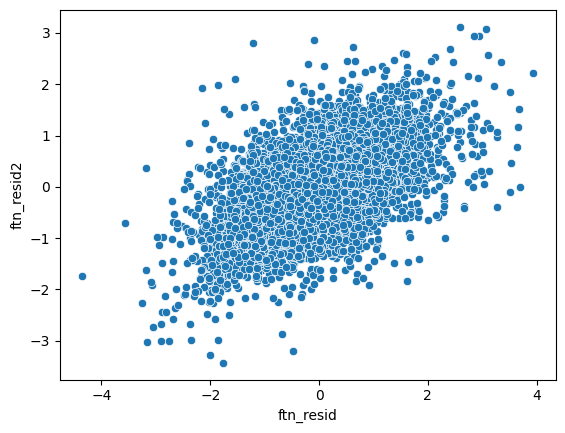

In [ ]:
sns.scatterplot(data=model_data, x='ftn_resid', y='ftn_resid2')
plt.show()

In [ ]:
new_feats

<IPython.core.display.Javascript object>

['starting_hash_code_sham',
 'qb_location_code_sham',
 'n_offense_backfield_code_sham',
 'n_defense_box_code_sham',
 'is_no_huddle_code_sham',
 'is_motion_code_sham']

In [ ]:
model_data.loc[:, ['ep','ep_pred', 'ep_ftn', 'ep_sham', 'ftn_resid', 'ftn_resid2']].sample(20)

<IPython.core.display.Javascript object>

,ep,ep_pred,ep_ftn,ep_sham,ftn_resid,ftn_resid2
53888,-0.818588,-0.645213,-0.347790,-0.638784,0.297424,0.290995
30758,-0.677325,-1.167076,-0.860390,-1.061119,0.306686,0.200729
23678,2.915007,3.904308,2.835481,2.987074,-1.068827,-0.151593
42022,0.307720,0.464216,0.431596,0.437817,-0.032620,-0.006221
22988,1.270815,0.951151,0.814090,1.231681,-0.137061,-0.417591
7724,4.884858,4.477382,4.504793,4.449826,0.027411,0.054967
4333,1.659750,2.346125,2.575937,2.361529,0.229812,0.214408
12528,-0.265826,-0.199130,-0.413055,-0.728609,-0.213925,0.315554
34888,3.795442,4.031026,4.453421,3.615247,0.422395,0.838173
29603,0.024518,0.041181,0.315218,0.330691,0.274037,-0.015473


### output explore

In [ ]:
model_data = pd.read_csv(f"{project_dir}/ftn_ep.csv")

Columns (179,180,182,183,189,190,193,194,205,206,218,219,220,222,224,226,243,244,245,253,254,255,260,262,263,283,284,301,303,306,332) have mixed types. Specify dtype option on import or set low_memory=False.


In [ ]:
_df = model_data.loc[:, ['passer_player_id', 'passer_player_name', 'ftn_resid2']].groupby(['passer_player_id', 'passer_player_name'], as_index=False).sum()
_df.sort_values('ftn_resid2', ascending=False).head(20)

<IPython.core.display.Javascript object>

,passer_player_id,passer_player_name,ftn_resid2
0,00-0019596,T.Brady,144.224369
66,00-0034857,J.Allen,91.188034
91,00-0036355,J.Herbert,89.443940
17,00-0029604,K.Cousins,86.492898
75,00-0035228,K.Murray,84.452528
94,00-0036442,J.Burrow,76.177418
101,00-0036971,T.Lawrence,70.236715
102,00-0036972,M.Jones,66.855566
3,00-0026143,M.Ryan,66.427592
92,00-0036389,J.Hurts,61.319119


In [ ]:
_df.sort_values('ftn_resid2', ascending=False).tail(20)

<IPython.core.display.Javascript object>

,passer_player_id,passer_player_name,ftn_resid2
98,00-0036900,J.Chase,-0.042921
84,00-0036145,L.Cager,-0.081791
60,00-0034418,C.Wilson,-0.086418
109,00-0037740,G.Wilson,-0.091580
25,00-0031381,D.Adams,-0.188357
83,00-0036133,J.Proche,-0.193975
72,00-0035100,J.Browning,-0.215316
54,00-0033908,C.Kupp,-0.215650
48,00-0033555,M.Hollins,-0.234339
43,00-0033280,C.McCaffrey,-0.250314


In [ ]:
_df = model_data.loc[model_data['is_motion']==1, ['passer_player_id', 'passer_player_name', 'ftn_resid']].groupby(['passer_player_id', 'passer_player_name'], as_index=False).sum()
_df.sort_values('ftn_resid', ascending=False).head(20)

<IPython.core.display.Javascript object>

,passer_player_id,passer_player_name,ftn_resid
0,00-0019596,T.Brady,25.905206
34,00-0033106,J.Goff,23.090187
66,00-0035228,K.Murray,21.951262
19,00-0030565,G.Smith,17.816179
46,00-0033873,P.Mahomes,16.995949
87,00-0036971,T.Lawrence,16.839626
59,00-0034857,J.Allen,16.238701
57,00-0034796,L.Jackson,15.338445
75,00-0036212,T.Tagovailoa,14.554466
79,00-0036355,J.Herbert,13.609775


In [ ]:
_df.sort_values('ftn_resid', ascending=False).tail(20)

<IPython.core.display.Javascript object>

,passer_player_id,passer_player_name,ftn_resid
81,00-0036442,J.Burrow,-1.056223
5,00-0026300,J.Johnson,-1.063193
24,00-0031503,J.Winston,-1.171303
98,00-0038108,B.Zappe,-1.253683
85,00-0036928,K.Trask,-1.417464
86,00-0036945,J.Fields,-1.482423
100,00-0038128,M.Willis,-1.633209
51,00-0034177,T.Boyle,-1.832188
36,00-0033275,P.Walker,-2.006244
3,00-0026158,J.Flacco,-2.248947


<IPython.core.display.Javascript object>

## feature importance

In [ ]:
new_feats = ['starting_hash', 'qb_location',
             'n_offense_backfield', 'n_defense_box',
             'is_no_huddle', 'is_motion']

feats = ['season', 'half_seconds_remaining',
         'yardline_100', 'pos_team_home',
         'roof_code', 'down',
         'ydstogo', 'era_code',
         'posteam_timeouts_remaining',
         'defteam_timeouts_remaining']

target = 'next_score_target_code'
n_classes = model_data[target].unique().shape[0]


for feat in new_feats:
  model_data[f"{feat}_code"] = model_data[feat].astype('category').cat.codes

new_feats = [f"{feat}_code" for feat in new_feats]
opt_pp = {
    'verbose': False,
    'loss_function': 'MultiClass',
    'classes_count': 7,
    'iterations': 537.0,
    'eta': 0.06052738333911695,
    'reg_lambda': 0.8371357521144646
}
model = cb.CatBoostClassifier(**opt_pp)
model.fit(model_data.loc[:, feats+new_feats], model_data[target])

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(model_data.loc[:, feats+new_feats])

shap_dict = {}
for idx, row in model_data.loc[:, ['next_score_target', target]].drop_duplicates().iterrows():
  shap_dict[row['next_score_target']] = pd.DataFrame(shap_values[row[target]], columns=feats+new_feats, index=model_data.index)

ftn_cols = [x for x in model_data.columns.values if '_ftn' in x]
shap_rename = {x:f"{x[:-5]}_shap" for x in new_feats}
_df = ((shap_dict['touchdown']
.add(shap_dict['fg']))
.div(2))
_df = _df.loc[:, new_feats]
_df = _df.rename(columns=shap_rename)
model_data = pd.concat([model_data, _df], axis=1)


<IPython.core.display.Javascript object>

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


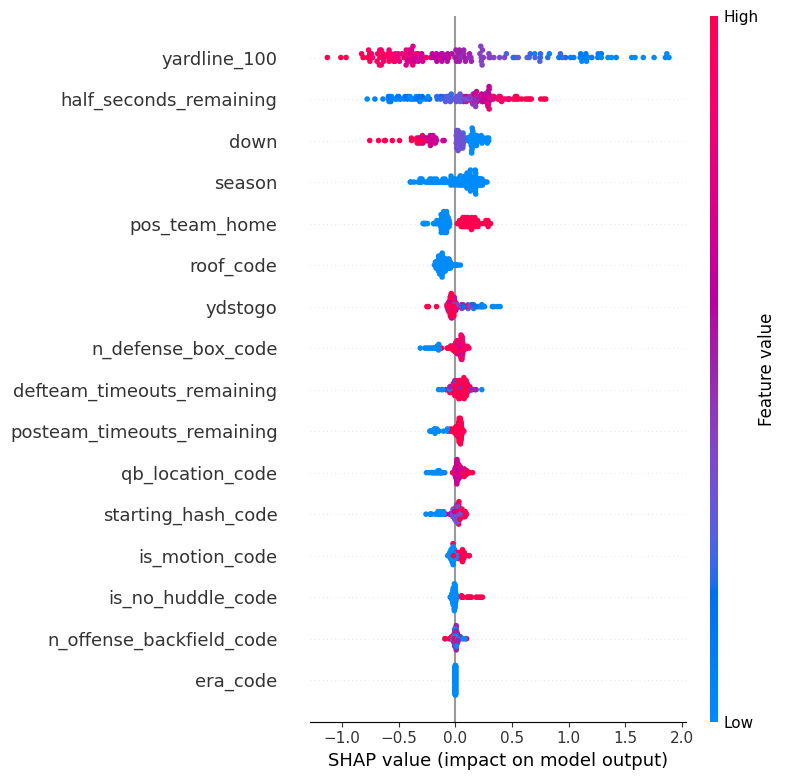

In [ ]:
shap.summary_plot(shap_values[6], model_data.loc[:, feats+new_feats], class_inds=model_data.loc[:, ['next_score_target', target]].drop_duplicates()[target].values, class_names=model_data.loc[:, ['next_score_target', target]].drop_duplicates()['next_score_target'].values)

<IPython.core.display.Javascript object>

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


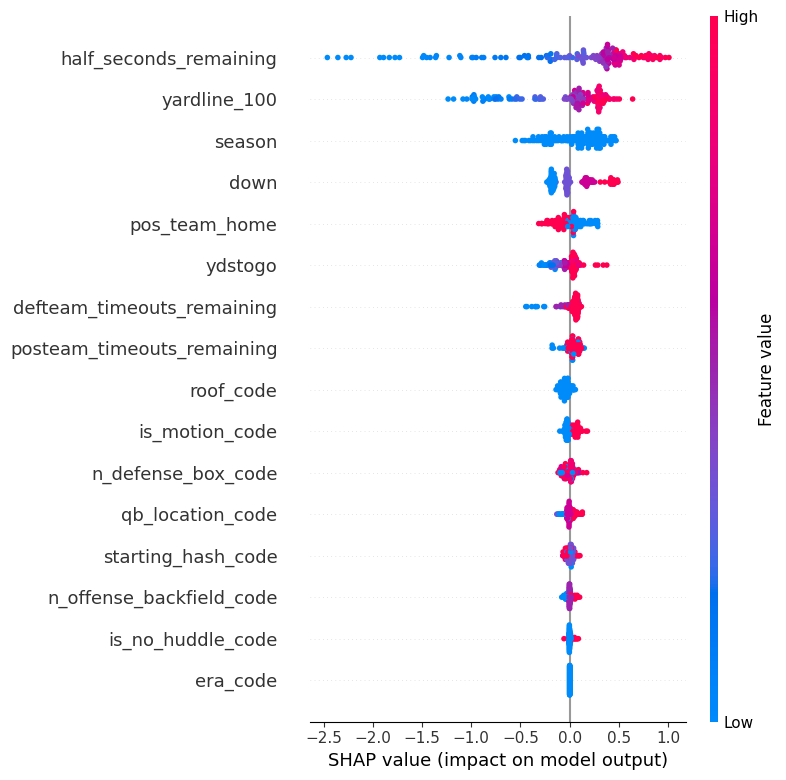

In [ ]:
shap.summary_plot(shap_values[4], shap_data.loc[:, feats+new_feats], class_inds=model_data.loc[:, ['next_score_target', target]].drop_duplicates()[target].values, class_names=model_data.loc[:, ['next_score_target', target]].drop_duplicates()['next_score_target'].values)

In [ ]:
shap_cols = [x for x in model_data.columns.values if '_shap' in x]

<IPython.core.display.Javascript object>

['starting_hash_shap',
 'qb_location_shap',
 'n_offense_backfield_shap',
 'n_defense_box_shap',
 'is_no_huddle_shap',
 'is_motion_shap']

In [ ]:
_df = model_data.loc[:, ['passer_player_id', 'passer_player_name', 'ftn_resid']+shap_cols].groupby(['passer_player_id', 'passer_player_name'], as_index=False).sum()
_df['shap_total'] = _df.loc[:, shap_cols].sum(axis=1)
_df.sort_values('is_motion_shap', ascending=False).head(20)

<IPython.core.display.Javascript object>

,passer_player_id,passer_player_name,ftn_resid,starting_hash_shap,qb_location_shap,n_offense_backfield_shap,n_defense_box_shap,is_no_huddle_shap,is_motion_shap,shap_total
85,00-0036212,T.Tagovailoa,17.192664,2.439641,-1.018147,2.932499,7.939018,-0.366186,11.122030,23.048855
52,00-0033873,P.Mahomes,59.093134,7.880469,-5.455359,-6.735434,10.161752,-5.069066,10.345097,11.127459
110,00-0037834,B.Purdy,16.060406,0.836270,0.045188,0.915607,1.992066,-1.220394,6.511999,9.080737
40,00-0033106,J.Goff,79.529251,6.569066,3.942246,-1.028755,9.390771,-2.298981,6.234966,22.809313
24,00-0031345,J.Garoppolo,9.456956,4.065866,-0.348854,-0.150447,3.865744,-0.243466,5.674869,12.863712
102,00-0036972,M.Jones,43.819612,3.206920,-0.654819,-2.546291,7.651502,1.388360,4.979210,14.024881
64,00-0034796,L.Jackson,35.928182,3.345387,-4.482373,1.009494,3.599350,-1.042774,4.613913,7.042996
113,00-0038122,D.Ridder,3.224941,0.624999,1.596378,1.393686,0.661459,1.963945,4.323938,10.564404
66,00-0034857,J.Allen,81.292311,5.851585,-1.484293,0.638722,9.942628,2.846197,3.668170,21.463008
0,00-0019596,T.Brady,144.412847,7.763482,1.615838,-3.617627,10.089760,13.997934,3.522840,33.372227


<IPython.core.display.Javascript object>

<Axes: xlabel='ftn_resid', ylabel='is_motion_shap'>

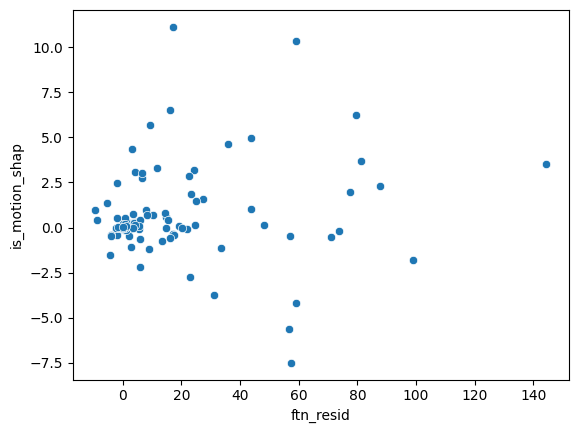

In [ ]:
sns.scatterplot(data=_df, x='ftn_resid', y='is_motion_shap')

In [ ]:
model_data.to_csv(f"{project_dir}/ftn_ep.csv", index=False)

<IPython.core.display.Javascript object>